In [15]:
import sys
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.append("..")
import helpers
import renderer
import testHelpers
renderingScene = 'staticViewPlaneLight'
jitterLightPos=False
jitterViewPos=False
mixMaterials=False
isTest = True
fixCrop = True
fixImageNb = True
cropSize = 256
batchSize = 1
maxInputToRead = 4
renderSize = 256
nbTargetsToRead = 4
nbTargets = 4
renderCropSize = renderSize
inputImageSize = 512

In [16]:
inputDir = '/Users/mendeza/Downloads/multi-image-deepNet-SVBRDF-acquisition-master/render_test/test'
pathList = list(Path(inputDir).glob('*.png'))
pathList = [str(i) for i in pathList]

In [17]:
pathList

['/Users/mendeza/Downloads/multi-image-deepNet-SVBRDF-acquisition-master/render_test/test/0_Shingles.png']

In [18]:
def __readMaterial(material):
    image_string = tf.read_file(material) #Gets a string tensor from a file
    decodedInput = tf.image.decode_image(image_string) #Decode a string tensor as image
    floatMaterial = tf.image.convert_image_dtype(decodedInput, dtype=tf.float32) #Transform image to float32

    return material, tf.split(floatMaterial, nbTargetsToRead, axis=1, name="Split_input_data1")
   #Materials are here of shape [batch, nbTargets, 256, 256, 3]
def __renderInputs( materials,
                       renderingScene,
                       jitterLightPos,
                       jitterViewPos,
                       mixMaterials,
                       isTest,
                       renderSize):
        mixedMaterial = materials
        print ('mixedMaterial: {}'.format(mixedMaterial.eval().shape))# (2, 4, 256, 256, 3)
        if mixMaterials:
            alpha = tf.random_uniform([1], minval=0.1, maxval=0.9, dtype=tf.float32, name="mixAlpha")
            #print("mat2: " + str(materials2))

            materials1 = materials[::2]# get 0,2 i.e normal and roughness
            materials2 = materials[1::2]# get 1,3, i.e. diffuse and albedo

            mixedMaterial = helpers.mixMaterials(materials1, materials2, alpha)# (1, 4, 256, 256, 3)
            print("mixedMaterial : {}".format(mixedMaterial.eval().shape))
        mixedMaterial.set_shape([None, nbTargetsToRead, renderSize, renderSize, 3])# (1, 4, 256, 256, 3)
        print("mixedMaterial2 : {}".format(mixedMaterial.eval().shape))
        mixedMaterial = helpers.adaptRougness(mixedMaterial)
        #These 3 lines below tries to scale the albedos to get more variety and to randomly flatten the normals to disambiguate the normals and albedos. We did not see strong effect for these.
        #if not isTest and self.useAugmentationInRenderings:
        #    mixedMaterial = helpers.adaptAlbedos(mixedMaterial, self.batchSize)
        #    mixedMaterial = helpers.adaptNormals(mixedMaterial, self.batchSize)

        reshaped_targets_batch = helpers.target_reshape(mixedMaterial) #reshape it to be compatible with the rendering algorithm [?, size, size, 12]
        nbRenderings = maxInputToRead
        if not fixImageNb:
            #If we don't want a constant number of input images, we randomly select a number of input images between 1 and the maximum number of images defined by the user.
            nbRenderings = tf.random_uniform([1],1, maxInputToRead + 1, dtype=tf.int32)[0]
        print("reshaped_targets_batch: {}".format(reshaped_targets_batch.eval().shape))
        rendererInstance = renderer.GGXRenderer(includeDiffuse = True)
        ## Do renderings of the mixedMaterial

        targetstoRender = reshaped_targets_batch
        pixelsToAdd = 0

        targetstoRender = helpers.preprocess(targetstoRender) #Put targets to -1; 1
        '''
        Generate a grid Y,X between -1;1 to act as the pixel support of the rendering 
        (computer the direction vector between each pixel and the light/view)
        '''
        surfaceArray = helpers.generateSurfaceArray(renderSize, pixelsToAdd)# (1, 1, 256, 256, 3)
        print("surfaceArray: {}".format(surfaceArray.eval().shape))
        #Do the renderings
        useAmbientLight=False
        useAugmentationInRenderings=False
        
        inputs = helpers.generateInputRenderings(rendererInstance,
                                                 targetstoRender,
                                                 batchSize,
                                                 nbRenderings,
                                                 surfaceArray,
                                                 renderingScene,
                                                 jitterLightPos,
                                                 jitterViewPos,
                                                 useAmbientLight,
                                                 useAugmentationInRenderings = useAugmentationInRenderings)
        print("inputs-afer_generateInputRenderings: {}".format(inputs.eval().shape))
        #inputs = [helpers.preprocess(input) for input in inputs]

        randomTopLeftCrop = tf.zeros([batchSize, nbRenderings, 2], dtype=tf.int32)
        averageCrop = 0.0
        
        #If we want to jitter the renderings around (to try to take into account small non alignment), we should handle the material crop a bit differently
        #We didn't really manage to get satisfying results with the jittering of renderings. But the code could be useful if this is of interest to Ansys.
        jitterRenderings = False
        if jitterRenderings:
            randomTopLeftCrop = tf.random_normal([batchSize, nbRenderings, 2], 0.0, 1.0)#renderSize - self.cropSize, dtype=tf.int32)
            randomTopLeftCrop = randomTopLeftCrop * tf.exp(tf.random_normal([batchSize], 0.0, 1.0))#renderSize - self.cropSize, dtype=tf.int32)
            randomTopLeftCrop = randomTopLeftCrop - tf.reduce_mean(randomTopLeftCrop, axis = 1, keep_dims=True)
            randomTopLeftCrop = tf.round(randomTopLeftCrop)
            randomTopLeftCrop = tf.cast(randomTopLeftCrop, dtype=tf.int32)
            averageCrop = tf.cast(axJitteringPixels * 0.5, dtype = tf.int32)
            randomTopLeftCrop = randomTopLeftCrop + averageCrop
            randomTopLeftCrop = tf.clip_by_value(randomTopLeftCrop, 0, maxJitteringPixels)
        
        totalCropSize = cropSize
        targets = targetstoRender
        firstAsGuide = False
        inputs, targets = helpers.cutSidesOut(inputs, targetstoRender, randomTopLeftCrop, totalCropSize, firstAsGuide, averageCrop)
        print("inputs: {}".format(inputs.eval().shape))
        print("targets: {}".format(targets.eval().shape))

        gammaCorrectedInputsBatch = inputs
        tf.summary.image("GammadInputs", helpers.convert(inputs[0, :]), max_outputs=5)
        inputs = tf.pow(inputs, 2.2) # correct gamma
        logInput=False
        if logInput:
            inputs = helpers.logTensor(inputs)

        inputs = helpers.preprocess(inputs)
        targets = helpers.target_deshape(targets, nbTargetsToRead)
        return targets, inputs, gammaCorrectedInputsBatch

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    filenamesTensor = tf.constant(pathList)
    #Reads a slice of the tensor, for example, if the tensor is of shape [100,2], the slice shape should be [2] (to check if we have problem here)
    dataset = tf.data.Dataset.from_tensor_slices(filenamesTensor)
    #for each slice apply the __readImages function
    dataset = dataset.map(__readMaterial, num_parallel_calls= 1) #Divided by four as the cluster divides cpu availiability for each GPU
    #Authorize repetition of the dataset when one epoch is over.
    dataset = dataset.repeat()
    # if shuffle:
    #     dataset = dataset.shuffle(buffer_size=256, reshuffle_each_iteration=True)
    #set batch size
    print(batchSize)
    nbWithdraw = 2 * batchSize# make batch size 2
    if not mixMaterials:
        nbWithdraw = batchSize
    batched_dataset = dataset.batch(nbWithdraw)
    batched_dataset = batched_dataset.prefetch(buffer_size=2)
    #batched_dataset = batched_dataset.cache()

    iterator = batched_dataset.make_initializable_iterator()
    sess.run(iterator.initializer)# initalize initalizer: https://stackoverflow.com/questions/48443203/tensorflow-getnext-failed-because-the-iterator-has-not-been-initialized


    #Create the node to retrieve next batch
    init_paths_batch, init_targets_batch = iterator.get_next()
    paths_batch = init_paths_batch
    print(init_targets_batch.eval().shape)# (2, 4, 256, 256, 3)
    t = init_targets_batch.eval()
    # plt.imshow(t[1][0])#normal
    # plt.show()
    # plt.imshow(t[1][1])#diffuse
    # plt.show()
    # plt.imshow(t[1][2])#roughness
    # plt.show()
    # plt.imshow(t[1][3])#specular
    # plt.show()
    '''
    Place jittering code from dataReader.py line 284 to 298 here
    '''
    if inputImageSize > renderCropSize:
        if fixCrop:
            xyCropping = (inputImageSize - renderCropSize) // 2
            xyCropping = [xyCropping, xyCropping]
        else:
            xyCropping = tf.random_uniform([1], 0, inputImageSize - renderCropSize, dtype=tf.int32)
        init_targets_batch = init_targets_batch[:,
                                                :,
                                                xyCropping[0] : xyCropping[0] + renderCropSize,
                                                xyCropping[0] : xyCropping[0] + renderCropSize, :]
        #Do the renderings
    targets_batch, inputs_batch, gammaCorrectedInputsBatch = __renderInputs(init_targets_batch,
                                                        renderingScene,
                                                        jitterLightPos,
                                                        jitterViewPos,
                                                        mixMaterials,
                                                        isTest,
                                                        renderCropSize)

    #Set the shapes (to make sure we have the proper dimension as we want). None means that it can be any number (but should have a dimension there), here we use it for the batch size and the number of input pictures that can vary.
    inputs_batch.set_shape([1, nbTargets, cropSize, cropSize, 3])
    targets_batch.set_shape([1, nbTargets, cropSize, cropSize, 3])

    gammaCorrectedInputsBatch.set_shape([batchSize, nbTargets, None, None, None])
    tensorOneInput, SurfaceLightFixedView, HemishpereLightFixedView = testHelpers.deprocess_images_fullTest(gammaCorrectedInputsBatch,targets_batch, nbTargets)
    # display_fetches = testHelpers.display_images_fetches_fullTest(paths_batch,
    #                                                   gammaCorrectedInputsBatch,
    #                                                   targets_batch,
    #                                                   nbTargets) 
    tensorOneInput = tensorOneInput.eval()
    SurfaceLightFixedView = SurfaceLightFixedView.eval()
    HemishpereLightFixedView = HemishpereLightFixedView.eval()
    # results = sess.run(display_fetches)
    # print(results)
    # print(inputs_batch.eval().shape)
    # print(targets_batch.eval().shape)


1
(1, 4, 512, 512, 3)
mixedMaterial: (1, 4, 256, 256, 3)
mixedMaterial2 : (1, 4, 256, 256, 3)
reshaped_targets_batch: (1, 256, 256, 12)
surfaceArray: (1, 1, 256, 256, 3)
use Augmentation ? : False
inputs-afer_generateInputRenderings: (1, 4, 256, 256, 3)
inputs: (1, 4, 256, 256, 3)
targets: (1, 256, 256, 12)


In [23]:
tensorOneInput.shape

(1, 256, 1280, 3)

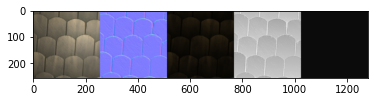

In [24]:
import matplotlib.pyplot as plt
plt.imshow(tensorOneInput[0])

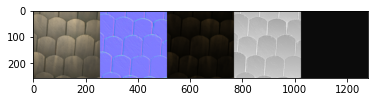

In [25]:
import matplotlib.pyplot as plt
plt.imshow(SurfaceLightFixedView[0])

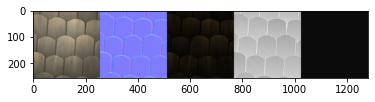

In [26]:
import matplotlib.pyplot as plt
plt.imshow(HemishpereLightFixedView[0])
